In [ ]:
# cloning the rgithub repository of fnc to get data in colab
!git clone https://github.com/veni-jindal/FakeNewsChallenge.git

Cloning into 'FakeNewsChallenge'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [ ]:
# importing required packages
import pandas as pd
import numpy as np
import os
from csv import DictReader
import re
import nltk
from sklearn import feature_extraction
nltk.download('wordnet')
nltk.download('punkt')
_wnl = nltk.WordNetLemmatizer()
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# cleaning text functions same as basline model
import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


# generating features 
def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)




def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X


In [ ]:
# reading the dataset from the fnc-1 data
class DataSet():
    def __init__(self, name, path="FakeNewsChallenge/fnc-1"):
        self.path = path

        print("Reading train dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"
        print(stances)

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))
    
    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [ ]:
'''GENERATING TRAIN VALIDATION SETS SPLIT SO THAT THE ARTICLE BODIES DON'T OVERLAP'''
# same as fnc-1 baseline
import random
import os
from collections import defaultdict


def generate_hold_out_split (dataset, training = 0.8, base_dir="splits"):
    r = random.Random()
    r.seed(1489215)

    article_ids = list(dataset.articles.keys())  # get a list of article ids
    r.shuffle(article_ids)  # and shuffle that list


    training_ids = article_ids[:int(training * len(article_ids))]
    hold_out_ids = article_ids[int(training * len(article_ids)):]

    # write the split body ids out to files for future use
    with open(base_dir+ "/"+ "training_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in training_ids]))

    with open(base_dir+ "/"+ "hold_out_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in hold_out_ids]))



def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
           ids.append(int(line))
        return ids


def kfold_split(dataset, training = 0.8, n_folds = 10, base_dir="./"):
    if not (os.path.exists(base_dir+ "/"+ "training_ids.txt")
            and os.path.exists(base_dir+ "/"+ "hold_out_ids.txt")):
        generate_hold_out_split(dataset,training,base_dir)

    training_ids = read_ids("training_ids.txt", base_dir)
    hold_out_ids = read_ids("hold_out_ids.txt", base_dir)

    folds = []
    for k in range(n_folds):
        folds.append(training_ids[int(k*len(training_ids)/n_folds):int((k+1)*len(training_ids)/n_folds)])

    return folds,hold_out_ids


def get_stances_for_folds(dataset,folds,hold_out):
    stances_folds = defaultdict(list)
    stances_hold_out = []
    for stance in dataset.stances:
        if stance['Body ID'] in hold_out:
            stances_hold_out.append(stance)
        else:
            fold_id = 0
            for fold in folds:
                if stance['Body ID'] in fold:
                    stances_folds[fold_id].append(stance)
                fold_id += 1

    return stances_folds,stances_hold_out


In [ ]:
import sys
import numpy as np
import pickle

#from utils.score import report_score, LABELS, score_submission
#from utils.system import parse_params, check_version


def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "hand."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap]
    return X,y



In [ ]:
# labels list
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
# labels - Related/Unrelated
LABELS_RELATED = ['unrelated','related']
# Getting the labels belonging to related category
RELATED = LABELS[0:3]

In [ ]:
# loading train stances and bodies
d= DataSet("train")
folds,hold_out = kfold_split(d,n_folds=1)
# train & validation stances
train_stances, val_stances = get_stances_for_folds(d,folds,hold_out)

# Load the competition dataset
competition_dataset = DataSet("competition_test")
X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")

Reading train dataset
train_stances.csv
Total stances: 49972
Total bodies: 1683


0it [00:00, ?it/s]

Reading train dataset
competition_test_stances.csv
Total stances: 25413
Total bodies: 904


25413it [01:20, 317.50it/s]
25413it [00:04, 5508.15it/s]
25413it [01:19, 320.01it/s]
25413it [01:25, 295.69it/s]


In [ ]:
# getting training & testing set
X_train, y_train = generate_features(train_stances[0], d, "train")
X_val, y_val = generate_features(val_stances, d, "validation")

40350it [02:12, 305.40it/s]
40350it [00:07, 5425.74it/s]
40350it [02:14, 300.84it/s]
40350it [02:25, 277.53it/s]
9622it [00:31, 300.84it/s]
9622it [00:01, 5352.55it/s]
9622it [00:32, 298.95it/s]
9622it [00:34, 280.22it/s]


In [ ]:
# importing required packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [ ]:
## Multi-layer feed-forward network
model = Sequential()
model.add(Dense(128, activation= 'relu',input_dim=44, kernel_regularizer= l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu', kernel_regularizer= l2(0.01)))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 14,276
Trainable params: 14,276
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# converting list to numpy arrays for neural network
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_competition)

In [ ]:
# training the model
history = model.fit(X_train,y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
631/631 [==============================] - 1s 2ms/step - loss: 0.8045 - accuracy: 0.8549 - val_loss: 0.5084 - val_accuracy: 0.8577
Epoch 2/100
631/631 [==============================] - 1s 2ms/step - loss: 0.4611 - accuracy: 0.8677 - val_loss: 0.4279 - val_accuracy: 0.8645
Epoch 3/100
631/631 [==============================] - 1s 1ms/step - loss: 0.4185 - accuracy: 0.8676 - val_loss: 0.4091 - val_accuracy: 0.8632
Epoch 4/100
631/631 [==============================] - 1s 2ms/step - loss: 0.4060 - accuracy: 0.8672 - val_loss: 0.4053 - val_accuracy: 0.8636
Epoch 5/100
631/631 [==============================] - 1s 1ms/step - loss: 0.4018 - accuracy: 0.8682 - val_loss: 0.4111 - val_accuracy: 0.8598
Epoch 6/100
631/631 [==============================] - 1s 1ms/step - loss: 0.4013 - accuracy: 0.8677 - val_loss: 0.3991 - val_accuracy: 0.8643
Epoch 7/100
631/631 [==============================] - 1s 1ms/step - loss: 0.3995 - accuracy: 0.8674 - val_loss: 0.3973 - val_accuracy: 0.8642

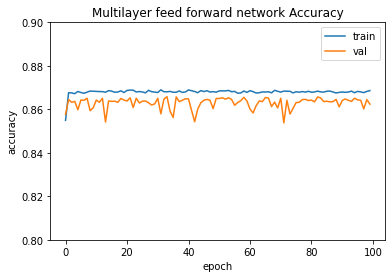

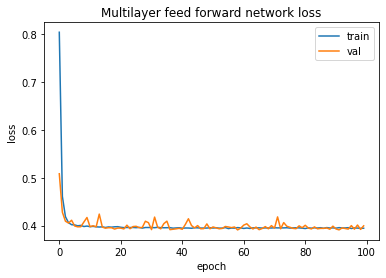

In [ ]:
# plotting accuracy and loss plots
import matplotlib.pyplot as plt
# summarize history for accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Multilayer feed forward network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.80,0.9])
plt.legend(['train', 'val'], loc='upper right')
fig.set_facecolor('white')
plt.show()
# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multilayer feed forward network loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
fig.set_facecolor('white')
plt.show()


In [ ]:
# evaluating model on test set
model.evaluate(X_competition, y_test)

795/795 [==============================] - 1s 788us/step - loss: 0.4670 - accuracy: 0.8491


[0.4670167863368988, 0.8490536212921143]

In [ ]:
# predictions on test set
y_test_pred = model.predict(X_competition)
pred_test = np.argmax(y_test_pred, axis = 1)
pred_test

array([3, 3, 3, ..., 3, 2, 2])

In [ ]:
# predictions on train set
y_train_pred = model.predict(X_train)
pred_train = np.argmax(y_train_pred, axis = 1)
pred_train

array([2, 3, 3, ..., 3, 2, 3])

In [ ]:
# predictions on val set
y_val_pred = model.predict(X_val)
pred_val = np.argmax(y_val_pred, axis = 1)
pred_val

array([3, 2, 3, ..., 3, 3, 2])

In [ ]:
# accuracy & f1 scores for test set
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
print("accuracy {}".format(accuracy_score(y_true = y_test, y_pred = pred_test)))
print("F1 score {}".format(f1_score(y_true = y_test, y_pred = pred_test, average='weighted')))
print(confusion_matrix(y_true =y_test, y_pred = pred_test))


accuracy 0.8490536339668674
F1 score 0.8062152835075163
[[    0     0  1499   404]
 [    0     0   381   316]
 [    0     0  3465   999]
 [    0     0   237 18112]]


In [ ]:
# accuracy & f1 scores for train set
print("accuracy {}".format(accuracy_score(y_true = y_train, y_pred = pred_train)))
print("F1 score {}".format(f1_score(y_true = y_train, y_pred = pred_train, average='weighted')))

accuracy 0.8674845105328377
F1 score 0.8307473843893589


In [ ]:
# accuracy & f1 scores for val set
print("accuracy {}".format(accuracy_score(y_true = y_val, y_pred = pred_val)))
print("F1 score {}".format(f1_score(y_true = y_val, y_pred = pred_val, average='weighted')))

accuracy 0.8623986697152359
F1 score 0.8226971130704173


In [ ]:
# function to get features of the unlabelled dataset
def features_competition(stances,dataset,name):
    h, b, body_id = [],[], []

    for stance in stances:
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
        body_id.append(stance['Body ID'])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "hand."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap]
    return X, h, body_id

class unlab_DataSet():
    def __init__(self, name, path="fnc-1"):
        self.path = path

        print("Reading test dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances_unlabeled.csv"
        print(stances)

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))
        
    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [ ]:
# load file 
competition_test = DataSet("competition_test")

Reading train dataset
competition_test_stances.csv
Total stances: 25413
Total bodies: 904


In [ ]:
# generate features from competition unlabelled dataset
X_competition_unlab, headline, body = features_competition(competition_test.stances, competition_test, "competition_unlabeled")

25413it [01:23, 305.54it/s]
25413it [00:04, 5334.30it/s]
25413it [01:23, 303.39it/s]
25413it [01:30, 280.26it/s]


In [ ]:
#Run on competition unlabelled dataset
predicted =  model.predict(X_competition_unlab)
y_pred = np.argmax(predicted, axis = 1)
pred_label = [LABELS[i] for i in y_pred]


In [ ]:
# dataframe for answer.csv
df = pd.DataFrame()
df['Headline'] = headline
df['Body ID'] = body
df['Stance'] = pred_label
print(df.head())
print(df.shape)
df.to_csv('answer.csv', index=False, encoding='utf-8') # From pandas library

                                            Headline  Body ID     Stance
0  Ferguson riots: Pregnant woman loses eye after...     2008  unrelated
1  Crazy Conservatives Are Sure a Gitmo Detainee ...     1550  unrelated
2  A Russian Guy Says His Justin Bieber Ringtone ...        2  unrelated
3  Zombie Cat: Buried Kitty Believed Dead, Meows ...     1793  unrelated
4  Argentina's President Adopts Boy to End Werewo...       37  unrelated
(25413, 3)
